### Variable Importance

In [1]:
import os
os.getcwd()
# os.chdir(path)    # or you can set your working dir.

'/Users/xingfuxu/PycharmProjects/EquityPremiumPredictionML-Jupyter'

In [2]:
# Your working dir should include "NN_models.py", Perform_CW_test.py" and "Perform_PT_test.py" files.
from Perform_CW_test import CW_test
from Perform_PT_test import PT_test
from NN_models import Net1, Net2, Net3, Net4, Net5

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
import torch
from skorch import NeuralNetRegressor
from tqdm import tqdm
#
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [4]:
# set seed
torch.manual_seed(1)
np.random.seed(1)

# read data
predictor_df = pd.read_excel(open('ml_equity_premium_data.xlsx', 'rb'), sheet_name='result_predictor')
predictor_df.head()

,month,log_equity_premium,equity_premium,DP,DY,EP,SVAR,BM,NTIS,TBL,...,MA_2_9,MA_2_12,MA_3_9,MA_3_12,MOM_1,MOM_2,MOM_3,MOM_6,MOM_9,MOM_12
0,192701,-0.005710,-0.00571,-2.942374,-2.963349,-2.374773,0.00047,0.44371,0.05082,3.23,...,1,1,1,1,0,0,1,1,1,1
1,192702,0.042017,0.04302,-2.979535,-2.932946,-2.430353,0.00029,0.42850,0.05167,3.29,...,1,1,1,1,1,1,1,1,1,1
2,192703,0.004697,0.00472,-2.976535,-2.970053,-2.445079,0.00092,0.46977,0.04636,3.20,...,1,1,1,1,1,1,1,1,1,1
3,192704,0.009940,0.01002,-2.984225,-2.967143,-2.471309,0.00060,0.45675,0.05051,3.39,...,1,1,1,1,1,1,1,1,1,1
4,192705,0.057987,0.05985,-3.025963,-2.975058,-2.531446,0.00039,0.43478,0.05528,3.33,...,1,1,1,1,1,1,1,1,1,1


In [5]:
# remove irrelavent columns
predictor0 = predictor_df.drop(['month', 'equity_premium'], axis=1)
# get all the predictors and set the log equity premium 1-month ahead
predictor = np.concatenate([predictor0['log_equity_premium'][1:].values.reshape(-1, 1),
                            predictor0.iloc[0:(predictor0.shape[0] - 1), 1:]], axis=1)

# number of rows
N = predictor.shape[0]

# number of all columns, including the log equity premium
n_cols = predictor.shape[1]

# Actual one-month ahead log equity premium
actual = predictor[:, [0]]

# Historical average forecasting as benchmark
y_pred_HA = predictor0['log_equity_premium'].values[0:(predictor0.shape[0] - 1), ].cumsum() / np.arange(1, N + 1)
y_pred_HA = y_pred_HA.reshape(-1, 1)

In [6]:
## Out-of-sample: 1957:01-2020:12
in_out_1957 = predictor_df.index[predictor_df['month'] == 195701][0]
actual_1957 = actual[in_out_1957:, ]
y_pred_HA_1957 = y_pred_HA[in_out_1957:, ]
MSFE_HA_1957 = mean_squared_error(y_pred_HA_1957, actual_1957)

In [7]:
def compute_oos_r_square(actual, y_benchmark, y_pred):
    MSFE_benchmark = mean_squared_error(y_benchmark, actual)
    MSFE_pred = mean_squared_error(y_pred, actual)
    return 1 - MSFE_pred / MSFE_benchmark

In [8]:
def get_oos_r_square_without_variable_i(i):
    y_pred_PLS_1957, y_pred_PCR_1957, y_pred_LASSO_1957 = [], [], []
    y_pred_ENet_1957, y_pred_RF_1957 = [], []
    y_pred_NN2_1957, y_pred_NN4_1957 = [], []
    y_pred_Ridge_1957 = []
    # control the update month of models during out-of-sample period. 
    month_index = 1  # We update our models annually, meaning we refresh them in months 1, 13, 25, ...
    #
    for t in tqdm(range(in_out_1957, N)):
        #
        X_train_all = predictor[:t, 1:n_cols].copy()
        y_train_all = predictor[:t, 0]
        # set the i-th predictor to 0: i ranges from 0 to 23
        X_train_all[:, i] = 0
        # set 15% of all the train data as validation set
        X_train = X_train_all[0:int(len(X_train_all) * 0.85), :]
        X_validation = X_train_all[int(len(X_train_all) * 0.85):t, :]
        y_train = y_train_all[0:int(len(X_train_all) * 0.85)]
        y_validation = y_train_all[int(len(X_train_all) * 0.85):t]
        #
        if month_index % 12 == 1:
            month_index += 1

            # PLS
            PLS_param = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8]}
            PLS_result = {}
            for param in ParameterGrid(PLS_param):
                PLS = PLSRegression(**param)
                PLS.fit(X_train, y_train)
                mse = mean_squared_error(PLS.predict(X_validation), y_validation)
                PLS_result[str(param)] = mse

            PLS_best_param = eval(min(PLS_result, key=PLS_result.get))
            PLS_model = PLSRegression(**PLS_best_param)
            PLS_model.fit(X_train_all, y_train_all)
            y_pred_PLS_1957.append(PLS_model.predict(predictor[[t], 1:n_cols])[0][0])

            # PCR
            PCR_param = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8]}
            PCR_result = {}
            for param in ParameterGrid(PCR_param):
                pca = PCA(**param)
                pca.fit(X_train)
                comps = pca.transform(X_train)
                forecast = LinearRegression()
                forecast.fit(comps, y_train)
                mse = mean_squared_error(forecast.predict(pca.transform(X_validation)), y_validation)
                PCR_result[str(param)] = mse
            #
            PCR_best_param = eval(min(PCR_result, key=PCR_result.get))
            #
            PCR_model = PCA(**PCR_best_param)
            PCR_model.fit(X_train_all)
            PCR_comps = PCR_model.transform(X_train_all)
            PCR_forecast = LinearRegression()
            PCR_forecast.fit(PCR_comps, y_train_all)
            y_pred_PCR_1957.append(PCR_forecast.predict(PCR_model.transform(predictor[[t], 1:n_cols]))[0])

            # LASSO
            LASSO_param = {'alpha': list(10 ** np.arange(-4, 1 + 0.001, 0.2))}
            LASSO_result = {}
            for param in ParameterGrid(LASSO_param):
                LASSO = Lasso(**param)
                LASSO.fit(X_train, y_train)
                mse = mean_squared_error(LASSO.predict(X_validation), y_validation)
                LASSO_result[str(param)] = mse
            #
            LASSO_best_param = eval(min(LASSO_result, key=LASSO_result.get))
            #
            LASSO_model = Lasso(**LASSO_best_param)
            LASSO_model.fit(X_train_all, y_train_all)
            y_pred_LASSO_1957.append(LASSO_model.predict(predictor[[t], 1:n_cols])[0])

            # ENet
            ENet_param = {'alpha': list(10 ** np.arange(-4, 1 + 0.001, 0.2)),
                          'l1_ratio': list(np.arange(0.2, 1, 0.3))}
            ENet_result = {}
            for param in ParameterGrid(ENet_param):
                ENet = ElasticNet(**param)
                ENet.fit(X_train, y_train)
                mse = mean_squared_error(ENet.predict(X_validation), y_validation)
                ENet_result[str(param)] = mse

            ENet_best_param = eval(min(ENet_result, key=ENet_result.get))
            ENet_model = ElasticNet(**ENet_best_param)
            ENet_model.fit(X_train_all, y_train_all)
            y_pred_ENet_1957.append(ENet_model.predict(predictor[[t], 1:n_cols])[0])

            # RF
            RF_param = {'n_estimators': [10, 50, 100, 150, 200],
                        'max_depth': [2, 3, 4],
                        'min_samples_leaf': [1, 3, 5]}
            RF_result = {}
            for param in ParameterGrid(RF_param):
                RF = RandomForestRegressor(**param)
                RF.fit(X_train, y_train)
                mse = mean_squared_error(RF.predict(X_validation), y_validation)
                RF_result[str(param)] = mse

            RF_best_param = eval(min(RF_result, key=RF_result.get))
            RF_model = RandomForestRegressor(**RF_best_param)
            RF_model.fit(X_train_all, y_train_all)
            y_pred_RF_1957.append(RF_model.predict(predictor[[t], 1:n_cols])[0])

            # Neural Network Models: NN2, NN4
            X_train_all_tensor = torch.tensor(X_train_all, dtype=torch.float)
            y_train_all_tensor = torch.tensor(y_train_all.reshape(-1, 1), dtype=torch.float)
            X_train_tensor = torch.tensor(X_train, dtype=torch.float)
            y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float)
            X_validation_tensor = torch.tensor(X_validation, dtype=torch.float)
            y_validation_tensor = torch.tensor(y_validation.reshape(-1, 1), dtype=torch.float)

            # NN2
            NN2_result = {}
            NN2_architecture = {"module__n_feature": X_train_tensor.shape[1],
                                "module__n_hidden1": 32, "module__n_hidden2": 16,
                                "module__n_output": 1}
            NN2_param = {'module__dropout': [0.2, 0.4, 0.6, 0.8],
                         'lr': [0.001, 0.01],
                         'optimizer__weight_decay': [0.1, 0.01, 0.001]}
            for param in ParameterGrid(NN2_param):
                NN2 = NeuralNetRegressor(Net2, verbose=0, max_epochs=200,
                                         optimizer=torch.optim.SGD,
                                         **NN2_architecture, **param)
                NN2.fit(X_train_tensor, y_train_tensor)
                mse = mean_squared_error(NN2.predict(X_validation_tensor), y_validation)
                NN2_result[str(param)] = mse

            #
            NN2_best_param = eval(min(NN2_result, key=NN2_result.get))
            NN2_model = NeuralNetRegressor(Net2, verbose=0, max_epochs=200, optimizer=torch.optim.SGD,
                                           **NN2_architecture, **NN2_best_param)
            NN2_model.fit(X_train_all_tensor, y_train_all_tensor)
            y_pred_NN2_1957.append(NN2_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])

            # NN4
            NN4_result = {}
            NN4_architecture = {"module__n_feature": X_train_tensor.shape[1],
                                "module__n_hidden1": 32, "module__n_hidden2": 16,
                                "module__n_hidden3": 8, "module__n_hidden4": 4,
                                "module__n_output": 1}
            NN4_param = {'module__dropout': [0.2, 0.4, 0.6, 0.8],
                         'lr': [0.001, 0.01],
                         'optimizer__weight_decay': [0.1, 0.01, 0.001]}
            for param in ParameterGrid(NN4_param):
                NN4 = NeuralNetRegressor(Net4, verbose=0, max_epochs=200,
                                         optimizer=torch.optim.SGD,
                                         **NN4_architecture, **param)
                NN4.fit(X_train_tensor, y_train_tensor)
                mse = mean_squared_error(NN4.predict(X_validation_tensor), y_validation)
                NN4_result[str(param)] = mse

            #
            NN4_best_param = eval(min(NN4_result, key=NN4_result.get))
            NN4_model = NeuralNetRegressor(Net4, verbose=0, max_epochs=200, optimizer=torch.optim.SGD,
                                           **NN4_architecture, **NN4_best_param)
            NN4_model.fit(X_train_all_tensor, y_train_all_tensor)
            y_pred_NN4_1957.append(NN4_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])

            ## Other commmonly used ML methods
            # Ridge
            Ridge_param = {'alpha': list(10 ** np.arange(0, 20 + 0.001, 1))}
            Ridge_result = {}
            for param in ParameterGrid(Ridge_param):
                RIDGE = Ridge(**param)
                RIDGE.fit(X_train, y_train)
                mse = mean_squared_error(RIDGE.predict(X_validation), y_validation)
                Ridge_result[str(param)] = mse
            #
            Ridge_best_param = eval(min(Ridge_result, key=Ridge_result.get))
            Ridge_model = Ridge(**Ridge_best_param)
            Ridge_model.fit(X_train_all, y_train_all)
            y_pred_Ridge_1957.append(Ridge_model.predict(predictor[[t], 1:n_cols])[0])

        else:
            month_index += 1
            y_pred_PLS_1957.append(PLS_model.predict(predictor[[t], 1:n_cols])[0][0])
            y_pred_PCR_1957.append(PCR_forecast.predict(PCR_model.transform(predictor[[t], 1:n_cols]))[0])
            y_pred_LASSO_1957.append(LASSO_model.predict(predictor[[t], 1:n_cols])[0])
            y_pred_ENet_1957.append(ENet_model.predict(predictor[[t], 1:n_cols])[0])
            y_pred_RF_1957.append(RF_model.predict(predictor[[t], 1:n_cols])[0])
            y_pred_NN2_1957.append(NN2_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
            y_pred_NN4_1957.append(NN4_model.predict(torch.tensor(predictor[[t], 1:n_cols], dtype=torch.float))[0][0])
            y_pred_Ridge_1957.append(Ridge_model.predict(predictor[[t], 1:n_cols])[0])

    y_ml_pred = pd.DataFrame(np.array([y_pred_PLS_1957, y_pred_PCR_1957, y_pred_LASSO_1957,
                                      y_pred_ENet_1957, y_pred_RF_1957, y_pred_NN2_1957,
                                      y_pred_NN4_1957, y_pred_Ridge_1957]),
                             index=['PLS', 'PCR', 'LASSO', 'ENet', 'RF', 'NN2', 'NN4', 'Ridge'],
                             columns=predictor_df.month[in_out_1957:N]).T

    return [compute_oos_r_square(actual_1957, y_pred_HA_1957, y_ml_pred[[col]].to_numpy()) for col in y_ml_pred.columns]

In [9]:
# Use parallel computation
from joblib import Parallel, delayed
variable_oos_result = Parallel(n_jobs=8)(delayed(get_oos_r_square_without_variable_i)(i) 
                                         for i in range(0, n_cols - 1))

100%|██████████| 767/767 [3:20:06<00:00, 15.65s/it]

In [10]:
variable_oos_result_df = pd.DataFrame(np.array(variable_oos_result), columns=['PLS', 'PCR', 'LASSO', 'ENet', 'RF', 'NN2', 'NN4', 'Ridge'],
                                     index=predictor0.columns[1:]).T
import openpyxl
with pd.ExcelWriter("ml_equity_premium_results.xlsx", engine='openpyxl', mode='a') as writer:
    variable_oos_result_df.to_excel(writer, sheet_name='variable_impt_oos_r2')
variable_oos_result_df

,DP,DY,EP,SVAR,BM,NTIS,TBL,LTR,TMS,DFY,...,MA_2_9,MA_2_12,MA_3_9,MA_3_12,MOM_1,MOM_2,MOM_3,MOM_6,MOM_9,MOM_12
PLS,-0.056668,-0.021803,-0.013873,-0.052092,-0.010886,-0.056247,-0.056455,-0.062457,-0.064312,-0.052722,...,-0.055355,-0.057813,-0.055789,-0.054598,-0.047386,-0.052381,-0.053342,-0.052642,-0.052720,-0.053575
PCR,0.000799,0.000579,0.006402,0.002305,0.000992,0.002303,0.003627,-0.002428,0.006657,-0.010740,...,0.002191,0.004051,0.008124,0.001475,-0.003088,-0.001252,-0.003999,0.004032,0.002445,0.005783
LASSO,-0.018778,-0.013721,-0.003283,-0.013721,-0.015613,-0.013721,-0.014837,-0.024034,-0.022172,-0.018722,...,-0.013703,-0.021336,-0.013678,-0.020282,-0.013857,-0.018609,-0.013691,-0.013721,-0.015582,-0.013291
ENet,-0.018660,-0.014154,-0.001841,-0.014154,-0.020287,-0.014154,-0.038179,-0.021420,-0.021344,-0.025237,...,-0.018231,-0.020161,-0.014092,-0.019235,-0.014241,-0.018159,-0.013942,-0.018110,-0.015150,-0.013895
RF,-0.117799,-0.064439,-0.090826,-0.087000,-0.087006,-0.195292,-0.067277,-0.074945,-0.092353,-0.068872,...,-0.055271,-0.077173,-0.111368,-0.189572,-0.078507,-0.107925,-0.082599,-0.113237,-0.061361,-0.061549
NN2,-0.058173,-0.155518,-0.129882,-0.065930,-0.212768,-0.171460,-0.135899,-0.125783,-0.076608,-0.133067,...,-0.087747,-0.114729,-0.102488,-0.040104,-0.084813,-0.155409,-0.106429,-0.117001,-0.092108,-0.040125
NN4,-0.364992,-0.175583,-0.054970,-0.102479,-0.185284,-0.052072,-0.103064,-0.206981,-0.192331,-0.171414,...,-0.097578,-0.253599,-0.127038,-0.253667,-0.059032,-0.198036,-0.136838,-0.166591,-0.131597,-0.088105
Ridge,-0.008840,-0.015531,0.000468,-0.011813,-0.015036,-0.011826,-0.038963,-0.025295,-0.019390,-0.025926,...,-0.011598,-0.013010,-0.010383,-0.011503,-0.011093,-0.014829,-0.012576,-0.010529,-0.010910,-0.009902


In [11]:
# "variable_importance_ranking"
selected_ml_models = ['PLS', 'PCR', 'LASSO', 'ENet', 'RF', 'NN2', 'NN4', 'Ridge']
ml_oos_performance = pd.read_excel(open("ml_equity_premium_results.xlsx", 'rb'), sheet_name='ml_oos_performance', index_col=[0])
oos_r_square_benchmark = ml_oos_performance.loc[selected_ml_models, 'oos_r_square']
oos_r_square_reduction_df = variable_oos_result_df.apply(lambda x: oos_r_square_benchmark - x * 100, raw=True).T
with pd.ExcelWriter("ml_equity_premium_results.xlsx", engine='openpyxl', mode='a') as writer:
    oos_r_square_reduction_df.to_excel(writer, sheet_name='variable_impt_r2_reduction')
oos_r_square_reduction_df

,PLS,PCR,LASSO,ENet,RF,NN2,NN4,Ridge
DP,0.478389,1.505838e-01,5.056998e-01,0.450601,4.614647,0.795335,25.652566,-0.296863
DY,-3.008162,1.725535e-01,3.756490e-07,0.000007,-0.721359,10.529864,6.711651,0.372302
EP,-3.801095,-4.097510e-01,-1.043798e+00,-1.231335,1.917351,7.966273,-5.349649,-1.227636
SVAR,0.020726,9.228823e-07,2.220446e-16,0.000000,1.534733,1.571080,-0.598734,0.000469
BM,-4.099857,1.312468e-01,1.891051e-01,0.613274,1.535283,16.254835,7.681732,0.322710
NTIS,0.436307,1.506630e-04,2.220446e-16,0.000000,12.363861,12.124056,-5.639461,0.001765
TBL,0.457050,-1.321814e-01,1.115461e-01,2.402465,-0.437573,8.568007,-0.540292,2.715404
LTR,1.057281,4.732389e-01,1.031208e+00,0.726520,0.329252,7.556427,9.851453,1.348696
TMS,1.242792,-4.352622e-01,8.450201e-01,0.718940,2.069979,2.638839,8.386474,0.758189
DFY,0.083802,1.304507e+00,5.000912e-01,1.108299,-0.278063,8.284786,6.294743,1.411767


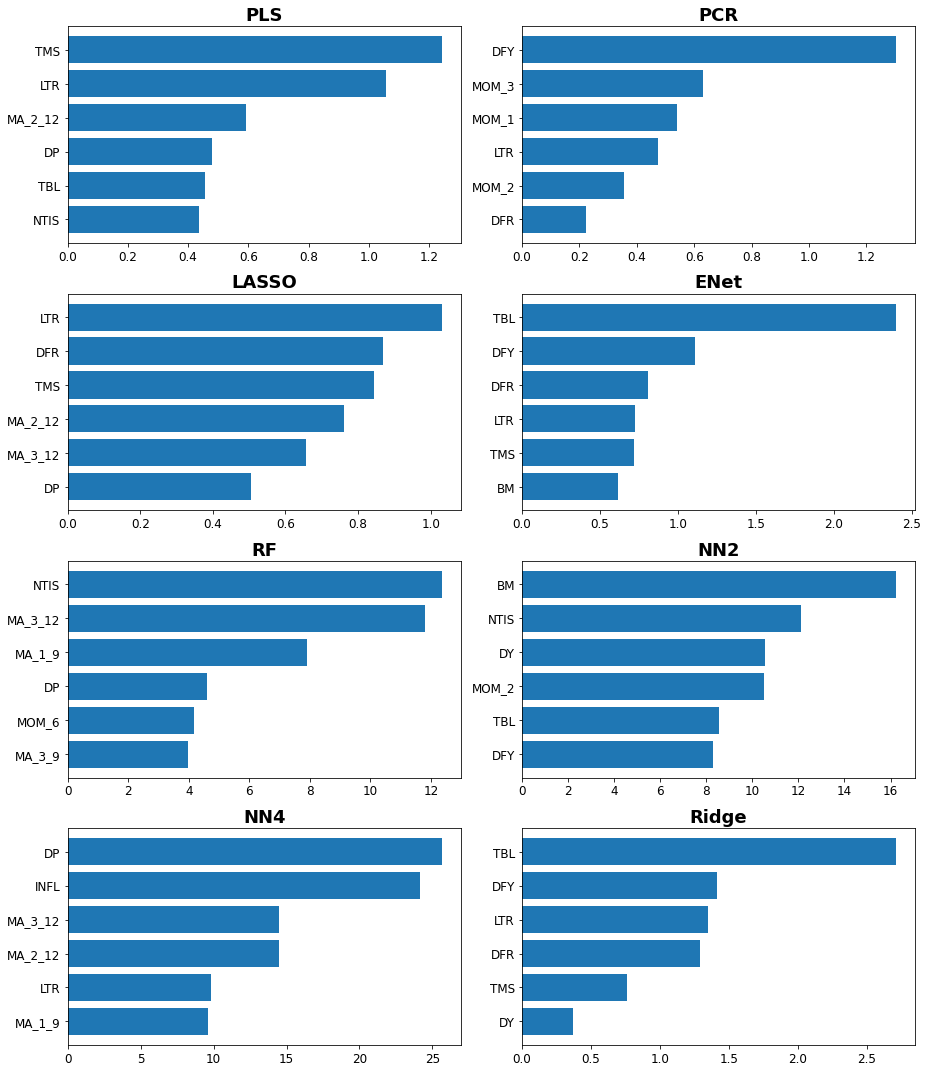

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(int(len(selected_ml_models) / 2), 2, figsize=(13, 15))
for i in range(1, len(selected_ml_models) + 1):
    ax_pos1 = int(i / 2) - 1 if i % 2 == 0 else int(i / 2)
    ax_pos2 = 1 if i % 2 == 0 else 0
    performance = oos_r_square_reduction_df.iloc[:, i - 1].sort_values(ascending=False)[:6]
    y_pos = np.arange(len(performance))
    ax[ax_pos1, ax_pos2].barh(y_pos, performance.to_numpy(), color='#1f77b4')
    ax[ax_pos1, ax_pos2].set_yticks(y_pos, labels=performance.index)
    ax[ax_pos1, ax_pos2].tick_params(axis='both', which='major', labelsize=12)
    ax[ax_pos1, ax_pos2].invert_yaxis()
    ax[ax_pos1, ax_pos2].set_title(label=performance.name, fontsize=18, fontweight='bold')

fig.tight_layout()
plt.savefig('Variable_implortance_ranking.png')
plt.show()